In [1]:
# ------------------------------------------------------------------------
#
# TITLE - paper_fig3_purity.ipynb
# AUTHOR - James Lane
# PROJECT - mw-dfs
#
# ------------------------------------------------------------------------
#
# Docstrings and metadata:
'''Make the final DF paper purity figures.
'''

__author__ = "James Lane"

In [2]:
### Imports

## Basic
import numpy as np, pdb, sys, copy, tqdm
import dill as pickle
import matplotlib.pyplot as plt
import matplotlib
import astropy.units as apu

## galpy
from galpy import potential
ro = 8.178 # Gravity 2019
vo = 220
zo = 0.0208 # Bennet + Bovy 2018

# scipy
import scipy.stats

sys.path.append('../../src/')
from mw_dfs import df as project_df
from mw_dfs import plot as project_plot

# Setup colors
project_colors = project_plot.colors()
plot_cmap = project_colors.colourmap('rainbow')

# Potential
mwpot = potential.MWPotential2014
potential.turn_physical_on(mwpot,ro=ro,vo=vo)

In [3]:
### Notebook setup
%matplotlib inline
plt.style.use('../../src/mpl/project.mplstyle')
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [4]:
### Keywords

# Directories
fig_dir = './fig/'
data_dir = '/geir_data/scr/lane/projects/mw-dfs/data/data_Sept_2021/df_samples/'

# High-Beta fraction
highbeta_frac = 0.5
lowbeta_frac = 1-highbeta_frac

# Oversampling factor
oversample_factor_halo = 100
oversample_factor_disk = 10
halo_disk_oversample_ratio = oversample_factor_halo /\
                             oversample_factor_disk

# Potential
phi0 = potential.evaluatePotentials(mwpot,1e12,0).value

# Load data

In [5]:
# Halo
with open(data_dir+'halo_orbits_solar.pkl','rb') as f:
    halo_orbs = pickle.load(f)
##wi
with open(data_dir+'halo_actions_solar.pkl','rb') as f:
    halo_actions = pickle.load(f)
##wi
with open(data_dir+'halo_eELzs_solar.pkl','rb') as f:
    halo_eELzs = pickle.load(f)
##wi
with open(data_dir+'halo_orbits_survey_os_factor'+\
          str(oversample_factor_halo)+'.pkl','rb') as f:
    halo_orbs_apo = pickle.load(f)
##wi
with open(data_dir+'halo_actions_survey_os_factor'+\
          str(oversample_factor_halo)+'.pkl','rb') as f:
    halo_actions_apo = pickle.load(f)
##wi
with open(data_dir+'halo_eELzs_survey_os_factor'+\
          str(oversample_factor_halo)+'.pkl','rb') as f:
    halo_eELzs_apo = pickle.load(f)
##wi

# Disk
with open(data_dir+'disk_orbits_solar.pkl','rb') as f:
    disk_orbs = pickle.load(f)
##wi
with open(data_dir+'disk_actions_solar.pkl','rb') as f:
    disk_actions = pickle.load(f)
##wi
with open(data_dir+'disk_eELzs_solar.pkl','rb') as f:
    disk_eELzs = pickle.load(f)
#wi
with open(data_dir+'disk_orbits_survey_os_factor'+\
          str(oversample_factor_disk)+'.pkl','rb') as f:
    disk_orbs_apo = pickle.load(f)
##wi
with open(data_dir+'disk_actions_survey_os_factor'+\
          str(oversample_factor_disk)+'.pkl','rb') as f:
    disk_actions_apo = pickle.load(f)
##wi
with open(data_dir+'disk_eELzs_survey_os_factor'+\
          str(oversample_factor_disk)+'.pkl','rb') as f:
    disk_eELzs_apo = pickle.load(f)
##wi

## Turn into lists for parsing

In [6]:
n_orbs_thin = len(disk_orbs_apo[0])
n_orbs_thick = len(disk_orbs_apo[1])
n_orbs_halo = len(halo_orbs_apo[0])

# Order is: betas [0, -0.5, 0.5, 0.7, 0.9] then thin disk, thick disk
orbs_all = [halo_orbs[0],halo_orbs[1],halo_orbs[2],halo_orbs[3],halo_orbs[4],
            disk_orbs[0],disk_orbs[1]]
eELzs_all = [halo_eELzs[0],halo_eELzs[1],halo_eELzs[2],halo_eELzs[3],
             halo_eELzs[4],disk_eELzs[0],disk_eELzs[1]]
actions_all = [halo_actions[0],halo_actions[1],halo_actions[2],halo_actions[3],
               halo_actions[4],disk_actions[0],disk_actions[1]]

orbs_all_apo = [halo_orbs_apo[0],halo_orbs_apo[1],halo_orbs_apo[2],
                halo_orbs_apo[3],halo_orbs_apo[4],disk_orbs_apo[0],
                disk_orbs_apo[1]]
eELzs_all_apo = [halo_eELzs_apo[0],halo_eELzs_apo[1],halo_eELzs_apo[2],
                 halo_eELzs_apo[3],halo_eELzs_apo[4],disk_eELzs_apo[0],
                 disk_eELzs_apo[1]]
actions_all_apo = [halo_actions_apo[0],halo_actions_apo[1],halo_actions_apo[2],
                   halo_actions_apo[3],halo_actions_apo[4],disk_actions_apo[0],
                   disk_actions_apo[1]]

isDisk = [False,False,False,False,False,True,True]

In [7]:
print(n_orbs_thin) # augmented by a factor of 10
print(n_orbs_thick) # augmented by a factor of 10
print(n_orbs_halo) # augmented by a factor of 100

1248790
235430
219800


## Create the mixture arrays that define what will be plotted

In [8]:
# Do specific mixture arrays
ergodic_mixture_arr = np.array([0.,0.,lowbeta_frac,0.,0.])
GE_mixture_arr = np.array([0.,0.,0.,0.,highbeta_frac])

# Ratio of thin to thick disk stars is ~1/8.5
disk_mixture_arr = np.array([1.0, 1.0/8.5])
# For APOGEE just use all thin and thick disc stars
disk_mixture_all_arr = np.array([1.0, 1.0])

mixture_text = [r'ergodic',
                r'$\beta=-0.5$',
                r'$\beta=0.5$',
                r'$\beta=0.7$',
                r'$\beta=0.9$',
                r'fiducial',
               ]

## Dictionaries to hold properties of specific kinematic spaces

In [9]:
kin_spaces = ['vRvT','Toomre','ELz','JRLz','eLz','AD']
n_kin_spaces = len(kin_spaces)

# Limits dictionary. [ [xmin,xmax], [ymin,ymax] ]
AD_dedge = 1.2
lims_dict = {'vRvT':   [[-450,450], [-450,450]],
             'Toomre': [[-450,450], [0,450]],
             'ELz':    [[-4500,4500], [-2.,-0.]],
             'JRLz':   [[-4500,4500], [0,80]],
             'eLz':    [[-4500,4500], [-0.05,1.05]],
             'AD':     [[-AD_dedge,AD_dedge], [-AD_dedge,AD_dedge]]
            }

# Labels dictionary. [xlabel, ylabel]
labels_dict = {'vRvT':   [r'$v_{R}$',r'$v_{T}$'],
               'Toomre': [r'$v_{T}$',r'$(v_{R}^{2}+v_{z}^{2})^{1/2}$'],
               'ELz':    [r'$L_{z}$',r'$(E-\Phi_{0})/10^{5}$'],
               'JRLz':   [r'$L_{z}$',r'$\sqrt{J_{R}}$'],
               'eLz':    [r'$L_{z}$',r'eccentricity'],
               'AD':     [r'$L_{z}/J_{tot}$',r'$(J_{z}-J_{R})/J_\mathrm{tot}$']
               }

# Selection dictionaries [ [xcent,ycent], [xmajor,ymajor] ] or [ [x1,x2], [y1,y2] ]
halo_selection_solar_dict = {'vRvT':   [ ['ellipse', [260,0], [140,20]], 
                                         ['ellipse', [-260,0], [140,20]] ],
                             'Toomre': [ ['ellipse', [0,200], [20,200]], ],
                             'ELz':    [ ['ellipse', [0,-0.9], [200,0.45]], ],
                             'JRLz':   [ ['ellipse', [0,45], [250,20]], ],
                             'eLz':    [ ['ellipse', [0,1], [500,0.025]], ],
                             'AD':     [ ['ellipse', [0,-1], [0.1,0.1]], ]
                             }

halo_selection_survey_dict = {'vRvT':   [ ['ellipse', [290,0], [110,35]], 
                                          ['ellipse', [-290,0], [110,35]] ],
                              'Toomre': [ ['ellipse', [0,300], [35,120]], ],
                              'ELz':    [ ['ellipse', [0,-1], [300,0.5]], ],
                              'JRLz':   [ ['ellipse', [0,45], [300,20]], ],
                              'eLz':    [ ['ellipse', [0,1], [500,0.025]], ],
                              'AD':     [ ['ellipse', [0,-1], [0.08,0.3]], ]
                              }
# Selection keywords
disk_selection_kws = {'linestyle':'solid', 'linewidth':1, 'facecolor':'None', 
                      'edgecolor':'Black', 'color':'Black', 'label':'Disc'}

halo_selection_kws = {'linestyle':'dashed', 'linewidth':1.5, 'facecolor':'None', 
                      'edgecolor':'Black', 'color':'Black', 'label':r'High-$\beta$'}


# Kinematics Grid Figures

In [10]:
# Seed for randomly picking samples 
seed = 7703

# Figure sizing
columnwidth = 240./72.27
textwidth = 504.0/72.27

# Plotting keywords
nbins = 40
bin_min = 5
contour_alpha = 1.
contour_zorder = 2
contour_linewidth = 1.5
contour_color = 'Black'
label_fontsize = 9

## Purity

### Solar

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide

../../src/mw_dfs/plot.py:72: UserWarning: Warning, absolute=False. Not using absolute mixture array fractions!
  warnings.warn('Warning, absolute=False. Not using absolute mixture array fractions!')

/usr/local/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label'
  s)



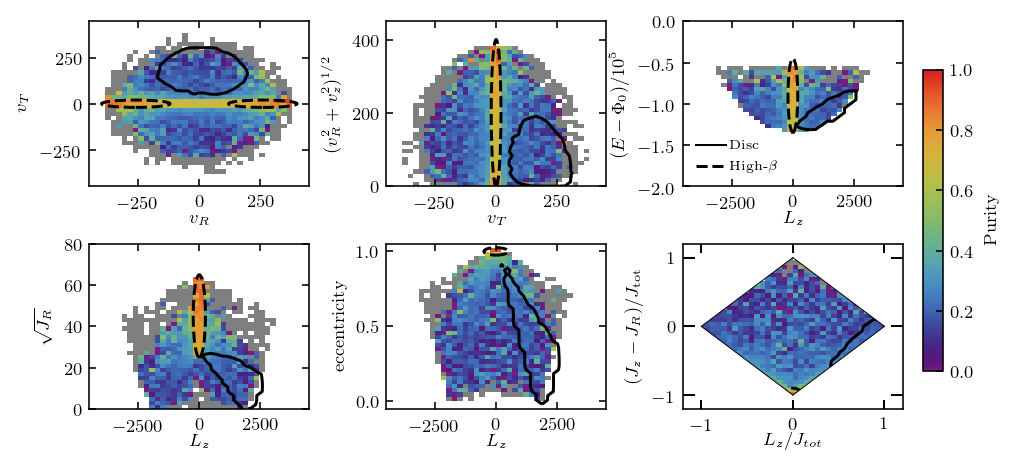

In [11]:
# Figure
fig = plt.figure()
fig.set_size_inches(textwidth,0.5*textwidth)
axs = fig.subplots(nrows=2, ncols=3).flatten()
for i in range( n_kin_spaces ):
    
    # Limits and labels
    xlim,ylim = lims_dict[kin_spaces[i]]
    xlabel,ylabel = labels_dict[kin_spaces[i]]
    xbinsize = (xlim[1]-xlim[0])/nbins
    ybinsize = (ylim[1]-ylim[0])/nbins
        
    # Purity
    xplot_erg,yplot_erg = project_plot.get_plottable_data( orbs_all[:5], eELzs_all[:5], 
        actions_all[:5], ergodic_mixture_arr, kin_spaces[i], phi0=phi0, seed=seed, absolute=True)
    xplot_GE,yplot_GE = project_plot.get_plottable_data( orbs_all[:5], eELzs_all[:5],
        actions_all[:5], GE_mixture_arr, kin_spaces[i], phi0=phi0, seed=seed, absolute=True) 
    hist_erg,_,_ = np.histogram2d(xplot_erg,yplot_erg,bins=nbins,
                                  range=[[xlim[0],xlim[1]],[ylim[0],ylim[1]]])
    hist_GE,_,_ = np.histogram2d(xplot_GE,yplot_GE,bins=nbins,
                                  range=[[xlim[0],xlim[1]],[ylim[0],ylim[1]]])
    GE_purity = np.divide( hist_GE , hist_GE + hist_erg )
    img = axs[i].imshow(np.rot90(GE_purity), cmap=plot_cmap, vmin=0, vmax=1, aspect='auto', 
          extent=(xlim[0],xlim[1],ylim[0],ylim[1]))
    
    # Find low-N bins. This will grey out bins with low numbers
    where_low_N = np.where( (hist_erg+hist_GE < bin_min) & (hist_erg+hist_GE > 0) )
    low_N_mask = np.zeros((nbins,nbins,4))
    low_N_mask[:,:,3] = 0.0
    low_N_mask[where_low_N[0],where_low_N[1],:3] = 0.5
    low_N_mask[where_low_N[0],where_low_N[1],3] = 1.0

    # Find 0-N bins. This will differentiate between no data and too little data
    where_no_N = np.where( hist_erg+hist_GE == 0 )
    no_N_mask = np.zeros((nbins,nbins,4))
    no_N_mask[:,:,3] = 0.0
    no_N_mask[where_no_N[0],where_no_N[1],:3] = 1.0
    no_N_mask[where_no_N[0],where_no_N[1],3] = 1.0
    
    low_N_img = axs[i].imshow(np.rot90(low_N_mask), aspect='auto', # interpolation='nearest',
                     extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    no_N_img = axs[i].imshow(np.rot90(no_N_mask), aspect='auto',# interpolation='nearest',
                         extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    
    # Decoration
    project_plot.axis_limits_and_labels(axs[i], xlim, ylim, xlabel, ylabel, mixture_text[i],
        is_left_edge=True, is_top_edge=False, label_fontsize=label_fontsize)
    if kin_spaces[i] == 'AD':
        project_plot.add_diamond_boundary(axs[i], dedge=AD_dedge)
    ##fi
    project_plot.add_selection_boundaries(axs[i], halo_selection_solar_dict[kin_spaces[i]],
                                               plot_kwargs=halo_selection_kws, plot_cent=False)

    xplot_disk ,yplot_disk = project_plot.get_plottable_data( orbs_all[5:], 
        eELzs_all[5:], actions_all[5:], disk_mixture_arr, kin_spaces[i], 
        phi0=phi0, seed=seed)
    hist,xedge,yedge = np.histogram2d(xplot_disk,yplot_disk,bins=nbins,
                                  range=[[xlim[0]-xbinsize,xlim[1]+xbinsize],
                                         [ylim[0]-ybinsize,ylim[1]+ybinsize]])
    xcents = xedge[:-1] + (xlim[1]-xlim[0])/nbins
    ycents = yedge[:-1] + (ylim[1]-ylim[0])/nbins
    xcnt,ycnt = np.meshgrid(xcents,ycents)
    axs[i].contour(xcnt, ycnt, hist.T, colors=contour_color, levels=[10,], 
        zorder=contour_zorder, alpha=contour_alpha, linewidths=contour_linewidth, 
        label='Disc')
    if i == 2:
        project_plot.add_legend(axs[i], disk_selection_kws, halo_selection_kws)
    ##fi
###i

fig.tight_layout()
fig.subplots_adjust(hspace=0.35, wspace=0.35, left=0.09, right=0.9)

cax = fig.add_axes([0.92,0.225,0.02,0.6])
cbar = fig.colorbar(img, cax=cax)
cbar.ax.tick_params(labelsize=label_fontsize)
cbar.set_label(r'Purity', fontsize=label_fontsize)

fig.savefig(fig_dir+'SolarHaloPurityGrid.pdf', rasterize=True, dpi=300)


### Survey

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide

/usr/local/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label'
  s)



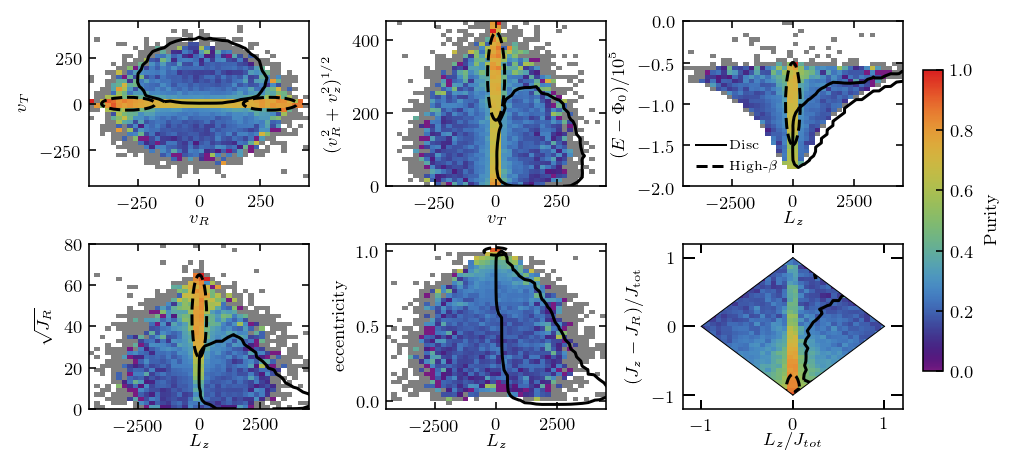

In [17]:
# Figure
fig = plt.figure()
fig.set_size_inches(textwidth,0.5*textwidth)
axs = fig.subplots(nrows=2, ncols=3).flatten()
for i in range( n_kin_spaces ):
    
    # Limits and labels
    xlim,ylim = lims_dict[kin_spaces[i]]
    xlabel,ylabel = labels_dict[kin_spaces[i]]
    xbinsize = (xlim[1]-xlim[0])/nbins
    ybinsize = (ylim[1]-ylim[0])/nbins
        
    # Purity
    xplot_erg,yplot_erg = project_plot.get_plottable_data( orbs_all_apo[:5], eELzs_all_apo[:5], 
        actions_all_apo[:5], ergodic_mixture_arr, kin_spaces[i], phi0=phi0, seed=seed, absolute=True)
    xplot_GE,yplot_GE = project_plot.get_plottable_data( orbs_all_apo[:5], eELzs_all_apo[:5],
        actions_all_apo[:5], GE_mixture_arr, kin_spaces[i], phi0=phi0, seed=seed, absolute=True) 
    hist_erg,_,_ = np.histogram2d(xplot_erg,yplot_erg,bins=nbins,
                                  range=[[xlim[0],xlim[1]],[ylim[0],ylim[1]]])
    hist_GE,_,_ = np.histogram2d(xplot_GE,yplot_GE,bins=nbins,
                                  range=[[xlim[0],xlim[1]],[ylim[0],ylim[1]]])
    GE_purity = np.divide( hist_GE , hist_GE + hist_erg )
    img = axs[i].imshow(np.rot90(GE_purity), cmap=plot_cmap, vmin=0, vmax=1, aspect='auto', 
          extent=(xlim[0],xlim[1],ylim[0],ylim[1]))
    
    # Find low-N bins. This will grey out bins with low numbers
    where_low_N = np.where( (hist_erg+hist_GE < bin_min) & (hist_erg+hist_GE > 0) )
    low_N_mask = np.zeros((nbins,nbins,4))
    low_N_mask[:,:,3] = 0.0
    low_N_mask[where_low_N[0],where_low_N[1],:3] = 0.5
    low_N_mask[where_low_N[0],where_low_N[1],3] = 1.0

    # Find 0-N bins. This will differentiate between no data and too little data
    where_no_N = np.where( hist_erg+hist_GE == 0 )
    no_N_mask = np.zeros((nbins,nbins,4))
    no_N_mask[:,:,3] = 0.0
    no_N_mask[where_no_N[0],where_no_N[1],:3] = 1.0
    no_N_mask[where_no_N[0],where_no_N[1],3] = 1.0
    
    low_N_img = axs[i].imshow(np.rot90(low_N_mask), aspect='auto', # interpolation='nearest',
                     extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    no_N_img = axs[i].imshow(np.rot90(no_N_mask), aspect='auto',# interpolation='nearest',
                         extent=[xlim[0],xlim[1],ylim[0],ylim[1]])

    # Decoration
    project_plot.axis_limits_and_labels(axs[i], xlim, ylim, xlabel, ylabel, mixture_text[i],
        is_left_edge=True, is_top_edge=False, label_fontsize=label_fontsize)
    if kin_spaces[i] == 'AD':
        project_plot.add_diamond_boundary(axs[i], dedge=AD_dedge)
    ##fi
    project_plot.add_selection_boundaries(axs[i], halo_selection_survey_dict[kin_spaces[i]],
                                               plot_kwargs=halo_selection_kws, plot_cent=False)

    xplot_disk ,yplot_disk = project_plot.get_plottable_data( orbs_all_apo[5:], eELzs_all_apo[5:], 
        actions_all_apo[5:], disk_mixture_all_arr, kin_spaces[i], phi0=phi0, seed=seed, absolute=True)

    # Remove stars where the sampling routine failed
    remove_bad_lowLz_stars = True
    if remove_bad_lowLz_stars:
        vR_disk, vT_disk = project_plot.get_plottable_data( orbs_all_apo[5:], eELzs_all_apo[5:], 
            actions_all_apo[5:], disk_mixture_all_arr, 'vRvT', phi0=phi0, seed=seed, 
            absolute=True)
        # Lowest "natural" stars in the sample at about vT~5.5
        where_bad_lowLz_stars = np.where( vT_disk > 5 )[0]
        xplot_disk = xplot_disk[where_bad_lowLz_stars]
        yplot_disk = yplot_disk[where_bad_lowLz_stars]
    ##fi

#     if kin_spaces[i] == 'ELz':
#         where_not_bad_disk = np.where(np.logical_or(xplot_disk>100,yplot_disk<-1))[0]
#         xplot_disk = xplot_disk[where_not_bad_disk]
#         yplot_disk = yplot_disk[where_not_bad_disk]
    hist,xedge,yedge = np.histogram2d(xplot_disk,yplot_disk,bins=nbins,
                                  range=[[xlim[0]-xbinsize,xlim[1]+xbinsize],
                                         [ylim[0]-ybinsize,ylim[1]+ybinsize]])
    xcents = xedge[:-1] + (xlim[1]-xlim[0])/nbins
    ycents = yedge[:-1] + (ylim[1]-ylim[0])/nbins
    xcnt,ycnt = np.meshgrid(xcents,ycents)
    axs[i].contour(xcnt, ycnt, hist.T, colors=contour_color, levels=[10,], 
                   zorder=contour_zorder, alpha=contour_alpha, linewidths=contour_linewidth, 
                   label='Disk')
    if i == 2:
        project_plot.add_legend(axs[i], disk_selection_kws, halo_selection_kws)
    ##fi
###i

fig.tight_layout()
fig.subplots_adjust(hspace=0.35, wspace=0.35, left=0.09, right=0.9)

cax = fig.add_axes([0.92,0.225,0.02,0.6])
cbar = fig.colorbar(img, cax=cax)
cbar.ax.tick_params(labelsize=label_fontsize)
cbar.set_label(r'Purity', fontsize=label_fontsize)

fig.savefig(fig_dir+'SurveyHaloPurityGrid.pdf', rasterize=True, dpi=300)

## Completeness-Purity from varying ellipses
Create a completeness-purity relation by varying the size and aspect ratio of the selection ellipses

#### Solar

In [ ]:
labels = [r'v$_{R}-$v$_{T}$','Toomre','E-L$_{z}$','J$_{R}-$L$_{z}$','e$-$L$_{z}$','AD']
colors=['Red','DarkOrange','DarkGreen','Lime','CornflowerBlue','Navy']

purity_cut = 0.8
completeness_cut = 0.3

n_per_dim = 25
n_samples = int(n_per_dim**2.)
x_factors, y_factors = np.meshgrid( np.linspace(-1,1,num=n_per_dim), 
                                    np.linspace(-1,1,num=n_per_dim) 
                                  )
x_factors = np.power(2,2*x_factors.flatten())
y_factors = np.power(2,2*y_factors.flatten())
factors_solar = np.array([x_factors,y_factors]).T

# Add the default ellipse so that it specifically can be plotted
factors_solar = np.vstack([factors_solar,[1.0,1.0]])
n_samples += 1

GE_ellipse_solar_purity = []
GE_ellipse_solar_completeness = []
GE_disk_ellipse_solar_purity = []
GE_good_solar_factor = []
GE_disk_good_solar_factor = []

for i in tqdm.tqdm(range(n_kin_spaces)):
    
    # seed_use = np.random.randint(0,10000,size=1)[0]
    seed_use = copy.copy(seed)
    
    # Purity and completeness
    xplot_erg,yplot_erg = project_plot.get_plottable_data( orbs_all[:5], eELzs_all[:5], 
        actions_all[:5], ergodic_mixture_arr, kin_spaces[i], phi0=phi0, seed=seed_use, absolute=True)
    xplot_GE,yplot_GE = project_plot.get_plottable_data( orbs_all[:5], eELzs_all[:5],
        actions_all[:5], GE_mixture_arr, kin_spaces[i], phi0=phi0, seed=seed_use, absolute=True)
    xplot_disk,yplot_disk = project_plot.get_plottable_data( orbs_all[5:], eELzs_all[5:], 
        actions_all[5:], disk_mixture_arr, kin_spaces[i], phi0=phi0, seed=seed_use, absolute=True)
    n_GE = len(xplot_GE)
    
    this_GE_purity = np.zeros(n_samples)
    this_GE_completeness = np.zeros(n_samples)
    this_GE_disk_purity = np.zeros(n_samples)
    this_selection = halo_selection_solar_dict[kin_spaces[i]]
    
    for j in range( n_samples ):
        erg_in_selec = project_plot.is_in_scaled_selection(xplot_erg, yplot_erg, 
            this_selection, factor=factors_solar[j])
        GE_in_selec = project_plot.is_in_scaled_selection(xplot_GE, yplot_GE, 
            this_selection, factor=factors_solar[j])
        disk_in_selec = project_plot.is_in_scaled_selection(xplot_disk, yplot_disk, 
            this_selection, factor=factors_solar[j])
        
        this_GE_purity[j] = np.sum(GE_in_selec) / ( np.sum(GE_in_selec) +\
                                                    np.sum(erg_in_selec) )
        this_GE_completeness[j] = np.sum(GE_in_selec) / n_GE
        this_GE_disk_purity[j] = np.sum(GE_in_selec) / ( np.sum(GE_in_selec) +\
                                                         np.sum(erg_in_selec) +\
                                                         np.sum(disk_in_selec) )
    ###j
    GE_ellipse_solar_purity.append(this_GE_purity)
    GE_ellipse_solar_completeness.append(this_GE_completeness)
    GE_disk_ellipse_solar_purity.append(this_GE_disk_purity)
    GE_good_solar_factor.append( np.where( (this_GE_purity > purity_cut) &\
                                           (this_GE_completeness > completeness_cut) )[0] )
    GE_disk_good_solar_factor.append( np.where( (this_GE_disk_purity > purity_cut) &\
                                                (this_GE_completeness > completeness_cut) )[0] )
###i

In [ ]:
# Figure
fig = plt.figure()
fig.set_size_inches(columnwidth,0.7*textwidth)
axs = fig.subplots(nrows=3, ncols=2).flatten()

for i in range( n_kin_spaces ):
    for j in range( n_kin_spaces ):

        this_GE_purity = GE_ellipse_solar_purity[j]
        this_GE_completeness = GE_ellipse_solar_completeness[j]
        this_disk_purity = GE_disk_ellipse_solar_purity[j]
                
        GE_stat,edges,_ = scipy.stats.binned_statistic(this_GE_completeness, this_GE_purity, 
                                                          statistic='mean', bins=8, range=(0,1))
        disk_stat,_,_ = scipy.stats.binned_statistic(this_GE_completeness, this_disk_purity, 
                                                              statistic='mean', bins=8, range=(0,1))
                
        cents = (edges[1:]+edges[:-1])/2
        
        GE_cents = cents[~np.isnan(GE_stat)]
        GE_stat = GE_stat[~np.isnan(GE_stat)]
        disk_cents = cents[~np.isnan(disk_stat)]
        disk_stat = disk_stat[~np.isnan(disk_stat)]
        
        if i == j:
            axs[i].plot(GE_cents, GE_stat, color=colors[j], linewidth=1.5, linestyle='solid',
                        alpha=1., zorder=5 )
            #axs[i].scatter( this_GE_completeness, this_GE_purity, marker='o', facecolor='Black', 
            #                s=0.2, alpha=0.1, zorder=3)
            axs[i].plot(disk_cents, disk_stat, color=colors[j], linewidth=1.5, linestyle='dashed',
                        alpha=1., zorder=5 )
            axs[i].scatter( this_GE_completeness[-1], this_GE_purity[-1], marker='o', facecolor=colors[j],
                            edgecolor='Black', s=15, zorder=6)
            #axs[i].scatter( combined_GE_completeness, combined_GE_purity, marker='x', facecolor='Black',
            #                edgecolor='Black', s=20, zorder=6)
        else:
            axs[i].plot(GE_cents, GE_stat, color=colors[j], linewidth=0.5, linestyle='solid',
                        alpha=0.5, zorder=4 )
    ###j
    if i in [4,5]:
        axs[i].set_xlabel(r'High$-\beta$ completeness', fontsize=label_fontsize)
    else:
        axs[i].tick_params(labelbottom=False)
    if i in [0,2,4]:
        axs[i].set_ylabel(r'High$-\beta$ purity', fontsize=label_fontsize)
    else:
        axs[i].tick_params(labelleft=False)
    ##ie
    axs[i].tick_params(axis='both', labelsize=label_fontsize)
    axs[i].set_ylim(0.,1.05)
    axs[i].set_xlim(0,1.)
    axs[i].annotate(labels[i], xy=(0.2,0.2), xycoords='axes fraction', fontsize=label_fontsize)
    #axs[i].plot([completeness_cut,completeness_cut], [purity_cut,1.0], linestyle='dotted', 
    #            color='Black', alpha=0.5, zorder=1)
    #axs[i].plot([completeness_cut,1.0], [purity_cut,purity_cut], linestyle='dotted', 
    #            color='Black', alpha=0.5, zorder=1)
###i

fig.subplots_adjust(left=0.2, right=0.95)
fig.savefig(fig_dir+'SolarHaloCompletenessPurity.pdf', rasterize=True, dpi=300)


In [ ]:
combined_selec_spaces_set = [['vRvT',],
                             ['Toomre',],
                             ['ELz',],
                             ['JRLz',],
                             ['eLz',],
                             ['AD',],
                             ['AD','JRLz'],
                             ['AD','eLz'],
                             ['AD','vRvT'],
                             ['eLz','JRLz'],
                             ['eLz','vRvT']]
n_spaces_set = len(combined_selec_spaces_set)
n_try = 20

for i in range(n_spaces_set):
    
    combined_GE_completeness = np.zeros(n_try)
    combined_GE_purity = np.zeros(n_try)
    combined_GE_disk_purity = np.zeros(n_try)
    n_combined_selec_spaces = len(combined_selec_spaces_set[i])
    
    # Extract data once
    for j in range(n_try):
        # seed_use = np.random.randint(0,10000,size=1)[0]
        seed_use = copy.copy(seed)
        for k in range(n_combined_selec_spaces):
            xplot_erg,yplot_erg = project_plot.get_plottable_data( orbs_all[:5], eELzs_all[:5], 
                actions_all[:5], ergodic_mixture_arr, combined_selec_spaces_set[i][k], phi0=phi0, seed=seed_use, absolute=True)
            xplot_GE,yplot_GE = project_plot.get_plottable_data( orbs_all[:5], eELzs_all[:5], 
                actions_all[:5], GE_mixture_arr, combined_selec_spaces_set[i][k], phi0=phi0, seed=seed_use, absolute=True)
            xplot_disk,yplot_disk = project_plot.get_plottable_data( orbs_all[5:], eELzs_all[5:], 
                actions_all[5:], disk_mixture_arr, combined_selec_spaces_set[i][k], phi0=phi0, seed=seed_use, absolute=True)
            this_selection = halo_selection_solar_dict[combined_selec_spaces_set[i][k]]

            if k == 0:
                combined_erg_in_selec = project_plot.is_in_scaled_selection(xplot_erg, yplot_erg, 
                    this_selection, factor=[1.,1.])
                combined_GE_in_selec = project_plot.is_in_scaled_selection(xplot_GE, yplot_GE, 
                    this_selection, factor=[1.,1.])
                combined_disk_in_selec = project_plot.is_in_scaled_selection(xplot_disk, yplot_disk, 
                    this_selection, factor=[1.,1.])
            else:
                combined_erg_in_selec = combined_erg_in_selec & project_plot.is_in_scaled_selection(xplot_erg, yplot_erg, 
                    this_selection, factor=[1.,1.])
                combined_GE_in_selec = combined_GE_in_selec & project_plot.is_in_scaled_selection(xplot_GE, yplot_GE, 
                    this_selection, factor=[1.,1.])
                combined_disk_in_selec = combined_disk_in_selec & project_plot.is_in_scaled_selection(xplot_disk, yplot_disk, 
                    this_selection, factor=[1.,1.])
            ##ie
        ###k
        combined_GE_purity[j] = np.sum(combined_GE_in_selec) / ( np.sum(combined_GE_in_selec) +\
                                        np.sum(combined_erg_in_selec) )
        combined_GE_completeness[j] = np.sum(combined_GE_in_selec) / len(combined_GE_in_selec)
        combined_GE_disk_purity[j] = np.sum(combined_GE_in_selec) / ( np.sum(combined_GE_in_selec) +\
                                        np.sum(combined_erg_in_selec) +\
                                        np.sum(combined_disk_in_selec))
    print(combined_selec_spaces_set[i])
    print('Combined completeness: '+str(round(np.mean(combined_GE_completeness),2))+' +/- '+str(round(np.std(combined_GE_completeness),2))  )
    print('Combined purity: '+str(round(np.mean(combined_GE_purity),2))+' +/- '+str(round(np.std(combined_GE_purity),2))  )
    print('Combined disk purity: '+str(round(np.mean(combined_GE_disk_purity),2))+' +/- '+str(round(np.std(combined_GE_disk_purity),2)) )
    print('\n')

#### Survey

In [ ]:
labels = [r'v$_{R}-$v$_{T}$','Toomre','E-L$_{z}$','J$_{R}-$L$_{z}$','e$-$L$_{z}$','AD']
colors=['Red','DarkOrange','DarkGreen','Lime','CornflowerBlue','MediumBlue']

purity_cut = 0.75
completeness_cut = 0.2

n_per_dim = 25
n_samples = int(n_per_dim**2.)
x_factors, y_factors = np.meshgrid( np.linspace(-1,1,num=n_per_dim), 
                                    np.linspace(-1,1,num=n_per_dim) 
                                  )
x_factors = np.power(2,2*x_factors.flatten())
y_factors = np.power(2,2*y_factors.flatten())
factors = np.array([x_factors,y_factors]).T

# Add the default ellipse so that it specifically can be plotted
factors = np.vstack([factors,[1.0,1.0]])
n_samples += 1

GE_ellipse_purity = []
GE_ellipse_completeness = []
GE_disk_ellipse_purity = []
GE_good_factor = []
GE_disk_good_factor = []

print(halo_selection_survey_dict)

for i in tqdm.tqdm(range(n_kin_spaces)):
    
    seed_use = np.random.randint(0,10000,size=1)[0]
    # seed_use = copy.copy(seed)
    
    # Purity and completeness
    xplot_erg,yplot_erg = project_plot.get_plottable_data( orbs_all_apo[:5], eELzs_all_apo[:5], 
        actions_all_apo[:5], ergodic_mixture_arr, kin_spaces[i], phi0=phi0, seed=seed_use, absolute=True)
    xplot_GE,yplot_GE = project_plot.get_plottable_data( orbs_all_apo[:5], eELzs_all_apo[:5],
        actions_all_apo[:5], GE_mixture_arr, kin_spaces[i], phi0=phi0, seed=seed_use, absolute=True)
    xplot_disk,yplot_disk = project_plot.get_plottable_data( orbs_all_apo[5:], eELzs_all_apo[5:], 
        actions_all_apo[5:], disk_mixture_all_arr, kin_spaces[i], phi0=phi0, seed=seed_use, absolute=True)
    n_GE = len(xplot_GE)
    
    this_GE_purity = np.zeros(n_samples)
    this_GE_completeness = np.zeros(n_samples)
    this_GE_disk_purity = np.zeros(n_samples)
    this_selection = halo_selection_survey_dict[kin_spaces[i]]
    
    for j in range( n_samples ):
        erg_in_selec = project_plot.is_in_scaled_selection(xplot_erg, yplot_erg, 
            this_selection, factor=factors[j])
        GE_in_selec = project_plot.is_in_scaled_selection(xplot_GE, yplot_GE, 
            this_selection, factor=factors[j])
        disk_in_selec = project_plot.is_in_scaled_selection(xplot_disk, yplot_disk, 
            this_selection, factor=factors[j])
        
        this_GE_purity[j] = np.sum(GE_in_selec) / ( np.sum(GE_in_selec) +\
                                                    np.sum(erg_in_selec) )
        this_GE_completeness[j] = np.sum(GE_in_selec) / n_GE
        this_GE_disk_purity[j] = np.sum(GE_in_selec) / ( np.sum(GE_in_selec) +\
                                                         np.sum(erg_in_selec) +\
                                                         np.sum(disk_in_selec)*halo_disk_oversample_ratio)
        print(str(j+1)+'/'+str(n_samples)+' done',end='\r')
    ###j*
    GE_ellipse_purity.append(this_GE_purity)
    GE_ellipse_completeness.append(this_GE_completeness)
    GE_disk_ellipse_purity.append(this_GE_disk_purity)
    GE_good_factor.append( np.where( (this_GE_purity > purity_cut) &\
                                     (this_GE_completeness > completeness_cut) )[0] )
    GE_disk_good_factor.append( np.where( (this_GE_disk_purity > purity_cut) &\
                                          (this_GE_completeness > completeness_cut) )[0] )
###i

In [ ]:
# Figure
fig = plt.figure()
fig.set_size_inches(columnwidth,0.7*textwidth)
axs = fig.subplots(nrows=3, ncols=2).flatten()

for i in range( n_kin_spaces ):
    for j in range( n_kin_spaces ):

        this_GE_purity = GE_ellipse_purity[j]
        this_GE_completeness = GE_ellipse_completeness[j]
        this_disk_purity = GE_disk_ellipse_purity[j]
                
        GE_stat,edges,_ = scipy.stats.binned_statistic(this_GE_completeness, this_GE_purity, 
                                                          statistic='mean', bins=20, range=(0,1))
        disk_stat,_,_ = scipy.stats.binned_statistic(this_GE_completeness, this_disk_purity, 
                                                              statistic='mean', bins=20, range=(0,1))
        cents = (edges[1:]+edges[:-1])/2
        GE_cents = cents[~np.isnan(GE_stat)]
        GE_stat = GE_stat[~np.isnan(GE_stat)]
        disk_cents = cents[~np.isnan(disk_stat)]
        disk_stat = disk_stat[~np.isnan(disk_stat)]
        
        if i == j:
            axs[i].plot(GE_cents, GE_stat, color=colors[j], linewidth=1.5, linestyle='solid',
                        alpha=1., zorder=5 )
            #axs[i].scatter( this_GE_completeness, this_GE_purity, marker='o', facecolor='Black', 
            #               s=0.2, alpha=0.1, zorder=3)
            axs[i].plot(disk_cents, disk_stat, color=colors[j], linewidth=1.5, linestyle='dashed',
                        alpha=1., zorder=5 )
            axs[i].scatter( this_GE_completeness[-1], this_GE_purity[-1], marker='o', facecolor=colors[j],
                            edgecolor='Black', s=15, zorder=6)
            # axs[i].scatter( combined_GE_completeness, combined_GE_purity, marker='x', facecolor='Grey',
            #                 edgecolor='Grey', s=20, zorder=7)
        else:
            axs[i].plot(GE_cents, GE_stat, color=colors[j], linewidth=0.5, linestyle='solid',
                        alpha=0.5, zorder=4 )
    ###j
    if i in [4,5]:
        axs[i].set_xlabel(r'High$-\beta$ completeness', fontsize=label_fontsize)
    else:
        axs[i].tick_params(labelbottom=False)
    if i in [0,2,4]:
        axs[i].set_ylabel(r'High$-\beta$ purity', fontsize=label_fontsize)
    else:
        axs[i].tick_params(labelleft=False)
    ##ie
    axs[i].tick_params(axis='both', labelsize=label_fontsize)
    axs[i].set_ylim(0.,1.05)
    axs[i].set_xlim(0,1.)
    axs[i].annotate(labels[i], xy=(0.2,0.2), xycoords='axes fraction', fontsize=label_fontsize)
###i

fig.subplots_adjust(left=0.2, right=0.95)
fig.savefig(fig_dir+'SurveyHaloCompletenessPurity.pdf', rasterize=True, dpi=300)


In [ ]:
space_ind = 5
plot_lim = 2.2
plot_purity_vmin = 0.65
plot_purity_vmax = 0.95
plot_completeness_vmin = 0.0
plot_completeness_vmax = 0.8

fig = plt.figure(figsize=(5,10))
ax1 = fig.add_subplot(311)


im1 = ax1.imshow(np.rot90(GE_ellipse_purity[space_ind][:-1].reshape((n_per_dim,n_per_dim))),
                  vmin=plot_purity_vmin,vmax=plot_purity_vmax, 
                  cmap=plot_cmap, extent=(-2.,2.,-2.,2.))
cb1 = plt.colorbar(im1)
cb1.set_label('Purity')
ax1.set_xlim(-plot_lim,plot_lim)
ax1.set_ylim(-plot_lim,plot_lim)
ax1.set_ylabel(r'$\log_{2}$[Y axis scale factor]')

ax2 = fig.add_subplot(312)
im2 = ax2.imshow(np.rot90(GE_disk_ellipse_purity[space_ind][:-1].reshape((n_per_dim,n_per_dim))),
                  vmin=plot_purity_vmin,vmax=plot_purity_vmax, 
                  cmap=plot_cmap, extent=(-2.,2.,-2.,2.))
cb2 = plt.colorbar(im2)
cb2.set_label('Disk purity')
ax2.set_xlim(-plot_lim,plot_lim)
ax2.set_ylim(-plot_lim,plot_lim)
ax2.set_ylabel(r'$\log_{2}$[Y axis scale factor]')

ax3 = fig.add_subplot(313)
im3 = ax3.imshow(np.rot90(GE_ellipse_completeness[space_ind][:-1].reshape((n_per_dim,n_per_dim))),
                  vmin=plot_completeness_vmin,vmax=plot_completeness_vmax, 
                  cmap=plot_cmap, extent=(-2.,2.,-2.,2.))
cb3 = plt.colorbar(im3)
cb3.set_label('Completeness')
ax3.set_xlim(-plot_lim,plot_lim)
ax3.set_ylim(-plot_lim,plot_lim)
ax3.set_xlabel(r'$\log_{2}$[X axis scale factor]')
ax3.set_ylabel(r'$\log_{2}$[Y axis scale factor]')

fig.tight_layout()
fig.savefig(fig_dir+'SurveyADCompletenessPurity.pdf', rasterize=True, dpi=300)
fig.show()

In [ ]:
combined_selec_spaces_set = [['vRvT',],
                             ['Toomre',],
                             ['ELz',],
                             ['JRLz',],
                             ['eLz',],
                             ['AD',],
                             ['AD','JRLz'],
                             ['AD','eLz'],
                             ['AD','vRvT'],
                             ['eLz','JRLz'],
                             ['eLz','vRvT'],
                             ['vRvT','Toomre'],
                             ['vRvT','ELz'],
                             ['vRvT','JRLz'],
                             ['Toomre','ELz'],
                             ['Toomre','JRLz'],
                             ['ELz','JRLz']]
n_spaces_set = len(combined_selec_spaces_set)
n_try = 5

for i in range(n_spaces_set):
    
    combined_GE_completeness = np.zeros(n_try)
    combined_GE_purity = np.zeros(n_try)
    combined_GE_disk_purity = np.zeros(n_try)
    n_combined_selec_spaces = len(combined_selec_spaces_set[i])
    
    # Extract data once
    for j in range(n_try):
        seed_use = np.random.randint(0,10000,size=1)[0]
        # seed_use = copy.copy(seed)
        for k in range(n_combined_selec_spaces):
            xplot_erg,yplot_erg = project_plot.get_plottable_data( orbs_all_apo[:5], eELzs_all_apo[:5], 
                actions_all_apo[:5], ergodic_mixture_arr, combined_selec_spaces_set[i][k], phi0=phi0, seed=seed_use, absolute=True)
            xplot_GE,yplot_GE = project_plot.get_plottable_data( orbs_all_apo[:5], eELzs_all_apo[:5], 
                actions_all_apo[:5], GE_mixture_arr, combined_selec_spaces_set[i][k], phi0=phi0, seed=seed_use, absolute=True)
            xplot_disk,yplot_disk = project_plot.get_plottable_data( orbs_all_apo[5:], eELzs_all_apo[5:], 
                actions_all_apo[5:], disk_mixture_all_arr, combined_selec_spaces_set[i][k], phi0=phi0, seed=seed_use, absolute=True)
            this_selection = halo_selection_survey_dict[combined_selec_spaces_set[i][k]]

            if k == 0:
                combined_erg_in_selec = project_plot.is_in_scaled_selection(xplot_erg, yplot_erg, 
                    this_selection, factor=[1.,1.])
                combined_GE_in_selec = project_plot.is_in_scaled_selection(xplot_GE, yplot_GE, 
                    this_selection, factor=[1.,1.])
                combined_disk_in_selec = project_plot.is_in_scaled_selection(xplot_disk, yplot_disk, 
                    this_selection, factor=[1.,1.])
            else:
                combined_erg_in_selec = combined_erg_in_selec & project_plot.is_in_scaled_selection(xplot_erg, yplot_erg, 
                    this_selection, factor=[1.,1.])
                combined_GE_in_selec = combined_GE_in_selec & project_plot.is_in_scaled_selection(xplot_GE, yplot_GE, 
                    this_selection, factor=[1.,1.])
                combined_disk_in_selec = combined_disk_in_selec & project_plot.is_in_scaled_selection(xplot_disk, yplot_disk, 
                    this_selection, factor=[1.,1.])
            ##ie
        ###k
        combined_GE_purity[j] = np.sum(combined_GE_in_selec) / ( np.sum(combined_GE_in_selec) +\
                                        np.sum(combined_erg_in_selec) )
        combined_GE_completeness[j] = np.sum(combined_GE_in_selec) / len(combined_GE_in_selec)
        combined_GE_disk_purity[j] = np.sum(combined_GE_in_selec) / ( np.sum(combined_GE_in_selec) +\
                                        np.sum(combined_erg_in_selec) +\
                                        np.sum(combined_disk_in_selec)*halo_disk_oversample_ratio)
    print(combined_selec_spaces_set[i])
    print('Combined completeness: '+str(round(np.mean(combined_GE_completeness),2))+' +/- '+str(round(np.std(combined_GE_completeness),2))  )
    print('Combined purity: '+str(round(np.mean(combined_GE_purity),2))+' +/- '+str(round(np.std(combined_GE_purity),2))  )
    print('Combined disk purity: '+str(round(np.mean(combined_GE_disk_purity),2))+' +/- '+str(round(np.std(combined_GE_disk_purity),2)) )
    print('\n')

# Literature GE Cuts

#### Myeong: $\lvert J_{\phi}/J_{tot} \rvert<0.07$, $(J_{z}-J_{R})/J_{tot}<-0.3$

In [ ]:
n_try = 20
use_survey = True
kin_space = 'AD'

lit_GE_purity = np.zeros(n_try)
lit_GE_completeness = np.zeros(n_try)
lit_GE_disk_purity = np.zeros(n_try)

# Loop over a few fiducial model creations
for i in range(n_try):
    if use_survey:
        use_eELzs = copy.deepcopy(eELzs_all_apo)
        use_orbs = copy.deepcopy(orbs_all_apo)
        use_actions = copy.deepcopy(actions_all_apo)
    else:
        use_eELzs = copy.deepcopy(eELzs_all)
        use_orbs = copy.deepcopy(orbs_all)
        use_actions = copy.deepcopy(actions_all)
    ##ie
    
    seed_use = np.random.randint(0,10000,size=1)[0]
    
    xplot_erg,yplot_erg = project_plot.get_plottable_data( use_orbs[:5], use_eELzs[:5], 
        use_actions[:5], ergodic_mixture_arr, kin_space, phi0=phi0, seed=seed_use, absolute=True)
    xplot_GE,yplot_GE = project_plot.get_plottable_data( use_orbs[:5], use_eELzs[:5],
        use_actions[:5], GE_mixture_arr, kin_space, phi0=phi0, seed=seed_use, absolute=True)
    xplot_disk,yplot_disk = project_plot.get_plottable_data( use_orbs[5:], use_eELzs[5:], 
        use_actions[5:], disk_mixture_all_arr, kin_space, phi0=phi0, seed=seed_use, absolute=True)
    
    x_data = [xplot_erg,xplot_GE,xplot_disk]
    y_data = [yplot_erg,yplot_GE,yplot_disk]
    in_selec = []
    n_GE = len(xplot_GE)
    
    for j in range(len(x_data)):
        this_in_selec = ( np.abs( x_data[j] ) < 0.07 ) & ( y_data[j] < -0.3 )
        in_selec.append(np.sum(this_in_selec))
    ###j
    
    lit_GE_purity[i] = in_selec[1] / ( in_selec[0] +\
                                       in_selec[1] )
    lit_GE_completeness[i] = in_selec[1] / n_GE
    lit_GE_disk_purity[i] = in_selec[1] / ( in_selec[0] +\
                                            in_selec[1] +\
                                            in_selec[2]*halo_disk_oversample_ratio )
    
###i
print( 'Purity: '+str(round(np.mean(lit_GE_purity),3)) ) 
print( 'Scatter: '+str(round(np.std(lit_GE_purity),3)) )
print('')      
print( 'Completeness: '+str(round(np.mean(lit_GE_completeness),3)) )
print( 'Scatter: '+str(round(np.std(lit_GE_completeness),3)) )
print('')   
print( 'Purity w.r.t/ Disk: '+str(round(np.mean(lit_GE_disk_purity),3)) )
print( 'Scatter: '+str(round(np.std(lit_GE_disk_purity),3)) )


#### Feuillet: $-500 < L_{z} < 500$, $\sqrt{J_{R}} > 30$

In [ ]:
n_try = 20
use_survey = True
kin_space = 'JRLz'

lit_GE_purity = np.zeros(n_try)
lit_GE_completeness = np.zeros(n_try)
lit_GE_disk_purity = np.zeros(n_try)

# Loop over a few fiducial model creations
for i in range(n_try):
    seed_use = np.random.randint(0,10000,size=1)[0]
    if use_survey:
        use_eELzs = copy.deepcopy(eELzs_all_apo)
        use_orbs = copy.deepcopy(orbs_all_apo)
        use_actions = copy.deepcopy(actions_all_apo)
    else:
        use_eELzs = copy.deepcopy(eELzs_all)
        use_orbs = copy.deepcopy(orbs_all)
        use_actions = copy.deepcopy(actions_all)
    ##ie
    
    seed_use = np.random.randint(0,10000,size=1)[0]
    
    xplot_erg,yplot_erg = project_plot.get_plottable_data( use_orbs[:5], use_eELzs[:5], 
        use_actions[:5], ergodic_mixture_arr, kin_space, phi0=phi0, seed=seed_use, absolute=True)
    xplot_GE,yplot_GE = project_plot.get_plottable_data( use_orbs[:5], use_eELzs[:5],
        use_actions[:5], GE_mixture_arr, kin_space, phi0=phi0, seed=seed_use, absolute=True)
    xplot_disk,yplot_disk = project_plot.get_plottable_data( use_orbs[5:], use_eELzs[5:], 
        use_actions[5:], disk_mixture_all_arr, kin_space, phi0=phi0, seed=seed_use, absolute=True)
    
    x_data = [xplot_erg,xplot_GE,xplot_disk]
    y_data = [yplot_erg,yplot_GE,yplot_disk]
    in_selec = []
    n_GE = len(xplot_GE)
    
    for j in range(len(x_data)):
        this_in_selec = ( np.abs( x_data[j] ) < 500 ) & ( y_data[j] > 30 )
        in_selec.append(np.sum(this_in_selec))
    ###j
    
    lit_GE_purity[i] = in_selec[1] / ( in_selec[0] +\
                                       in_selec[1] )
    lit_GE_completeness[i] = in_selec[1] / n_GE
    lit_GE_disk_purity[i] = in_selec[1] / ( in_selec[0] +\
                                            in_selec[1] +\
                                            in_selec[2]*halo_disk_oversample_ratio )
    
###i
print( 'Purity: '+str(round(np.mean(lit_GE_purity),3)) ) 
print( 'Scatter: '+str(round(np.std(lit_GE_purity),3)) )
print('')      
print( 'Completeness: '+str(round(np.mean(lit_GE_completeness),3)) )
print( 'Scatter: '+str(round(np.std(lit_GE_completeness),3)) )
print('')   
print( 'Completeness w/ Disk: '+str(round(np.mean(lit_GE_disk_purity),3)) )
print( 'Scatter: '+str(round(np.std(lit_GE_disk_purity),3)) )

#### Naidu eccentricity > 0.7 cut

In [ ]:
n_try = 20
use_survey = True
kin_space = 'eLz'

lit_GE_purity = np.zeros(n_try)
lit_GE_completeness = np.zeros(n_try)
lit_GE_disk_purity = np.zeros(n_try)

# Loop over a few fiducial model creations
for i in range(n_try):
    seed_use = np.random.randint(0,10000,size=1)[0]
    if use_survey:
        use_eELzs = copy.deepcopy(eELzs_all_apo)
        use_orbs = copy.deepcopy(orbs_all_apo)
        use_actions = copy.deepcopy(actions_all_apo)
    else:
        use_eELzs = copy.deepcopy(eELzs_all)
        use_orbs = copy.deepcopy(orbs_all)
        use_actions = copy.deepcopy(actions_all)
    ##ie
    
    xplot_erg,yplot_erg = project_plot.get_plottable_data( use_orbs[:5], use_eELzs[:5], 
        use_actions[:5], ergodic_mixture_arr, kin_space, phi0=phi0, seed=seed_use, absolute=True)
    xplot_GE,yplot_GE = project_plot.get_plottable_data( use_orbs[:5], use_eELzs[:5],
        use_actions[:5], GE_mixture_arr, kin_space, phi0=phi0, seed=seed_use, absolute=True)
    xplot_disk,yplot_disk = project_plot.get_plottable_data( use_orbs[5:], use_eELzs[5:], 
        use_actions[5:], disk_mixture_all_arr, kin_space, phi0=phi0, seed=seed_use, absolute=True)
    
    x_data = [xplot_erg,xplot_GE,xplot_disk]
    y_data = [yplot_erg,yplot_GE,yplot_disk]
    in_selec = []
    n_GE = len(xplot_GE)
    
    for j in range(len(x_data)):
        this_in_selec = ( np.abs( y_data[j] ) > 0.7 )
        in_selec.append(np.sum(this_in_selec))
    ###j
    
    lit_GE_purity[i] = in_selec[1] / ( in_selec[0] +\
                                       in_selec[1] )
    lit_GE_completeness[i] = in_selec[1] / n_GE
    lit_GE_disk_purity[i] = in_selec[1] / ( in_selec[0] +\
                                            in_selec[1] +\
                                            in_selec[2]*halo_disk_oversample_ratio )
    
###i
print( 'Purity: '+str(round(np.mean(lit_GE_purity),3)) ) 
print( 'Scatter: '+str(round(np.std(lit_GE_purity),3)) )
print('')      
print( 'Completeness: '+str(round(np.mean(lit_GE_completeness),3)) )
print( 'Scatter: '+str(round(np.std(lit_GE_completeness),3)) )
print('')   
print( 'Purity w/ Disk: '+str(round(np.mean(lit_GE_disk_purity),3)) )
print( 'Scatter: '+str(round(np.std(lit_GE_disk_purity),3)) )

#### Just E-Lz

In [ ]:
n_try = 20
use_survey = True
kin_space = 'ELz'

lit_GE_purity = np.zeros(n_try)
lit_GE_completeness = np.zeros(n_try)
lit_GE_disk_purity = np.zeros(n_try)

# Loop over a few fiducial model creations
for i in range(n_try):
    if use_survey:
        use_eELzs = copy.deepcopy(eELzs_all_apo)
        use_orbs = copy.deepcopy(orbs_all_apo)
        use_actions = copy.deepcopy(actions_all_apo)
    else:
        use_eELzs = copy.deepcopy(eELzs_all)
        use_orbs = copy.deepcopy(orbs_all)
        use_actions = copy.deepcopy(actions_all)
    ##ie
    
    seed_use = np.random.randint(0,10000,size=1)[0]
    
    xplot_erg,yplot_erg = project_plot.get_plottable_data( use_orbs[:5], use_eELzs[:5], 
        use_actions[:5], ergodic_mixture_arr, kin_space, phi0=phi0, seed=seed_use, absolute=True)
    xplot_GE,yplot_GE = project_plot.get_plottable_data( use_orbs[:5], use_eELzs[:5],
        use_actions[:5], GE_mixture_arr, kin_space, phi0=phi0, seed=seed_use, absolute=True)
    xplot_disk,yplot_disk = project_plot.get_plottable_data( use_orbs[5:], use_eELzs[5:], 
        use_actions[5:], disk_mixture_all_arr, kin_space, phi0=phi0, seed=seed_use, absolute=True)
    
    x_data = [xplot_erg,xplot_GE,xplot_disk]
    y_data = [yplot_erg,yplot_GE,yplot_disk]
    in_selec = []
    n_GE = len(xplot_GE)
    
    for j in range(len(x_data)):
        this_in_selec = project_plot.is_in_scaled_selection(x_data[j], y_data[j], 
            halo_selection_survey_dict[kin_space], factor=[1.,1.])
        in_selec.append(np.sum(this_in_selec))
    ###j
    
    lit_GE_purity[i] = in_selec[1] / ( in_selec[0] +\
                                       in_selec[1] )
    lit_GE_completeness[i] = in_selec[1] / n_GE
    lit_GE_disk_purity[i] = in_selec[1] / ( in_selec[0] +\
                                            in_selec[1] +\
                                            in_selec[2]*halo_disk_oversample_ratio )
    
###i
print( 'Purity: '+str(round(np.mean(lit_GE_purity),3)) ) 
print( 'Scatter: '+str(round(np.std(lit_GE_purity),3)) )
print('')      
print( 'Completeness: '+str(round(np.mean(lit_GE_completeness),3)) )
print( 'Scatter: '+str(round(np.std(lit_GE_completeness),3)) )
print('')   
print( 'Purity w/ Disk: '+str(round(np.mean(lit_GE_disk_purity),3)) )
print( 'Scatter: '+str(round(np.std(lit_GE_disk_purity),3)) )